<a href="https://colab.research.google.com/github/KoheiNika/repository_new/blob/master/imagenette_efficientnet_advprop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 2.x is not compatible with cleverhans (placeholder etc)
# 1.x cannot load Efficient-Net model
# use 2.x and don't use cleverhans
%tensorflow_version 2.x

In [2]:
import numpy as np
import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [3]:
print(tf.__version__)

2.2.0


In [4]:
# imagenetの一部分を抽出したdatasetのimagenetteを用いる（colab の無料版の制約による）
data_root = tf.keras.utils.get_file(
  'imagenette2-320','https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-320.tgz',
   untar=True)

341557248/341553947 [==============================] - 5s 0us/step


In [5]:
print(data_root)
IMAGE_SHAPE = (224, 224)
#training directory
train_dir = str(data_root) + "/train"
adv_dir = str(data_root) + "/adv"

from distutils.dir_util import  copy_tree
copy_tree(train_dir, adv_dir)

image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
image_data = image_generator.flow_from_directory(str(train_dir), target_size=IMAGE_SHAPE)
adv_image_data = image_generator.flow_from_directory(str(adv_dir), target_size=IMAGE_SHAPE)
print(image_data.filepaths)
print(adv_image_data.filepaths)

/root/.keras/datasets/imagenette2-320
Found 9469 images belonging to 10 classes.
Found 9469 images belonging to 10 classes.
['/root/.keras/datasets/imagenette2-320/train/n01440764/ILSVRC2012_val_00000293.JPEG', '/root/.keras/datasets/imagenette2-320/train/n01440764/ILSVRC2012_val_00002138.JPEG', '/root/.keras/datasets/imagenette2-320/train/n01440764/ILSVRC2012_val_00003014.JPEG', '/root/.keras/datasets/imagenette2-320/train/n01440764/ILSVRC2012_val_00006697.JPEG', '/root/.keras/datasets/imagenette2-320/train/n01440764/ILSVRC2012_val_00007197.JPEG', '/root/.keras/datasets/imagenette2-320/train/n01440764/ILSVRC2012_val_00009346.JPEG', '/root/.keras/datasets/imagenette2-320/train/n01440764/ILSVRC2012_val_00009379.JPEG', '/root/.keras/datasets/imagenette2-320/train/n01440764/ILSVRC2012_val_00009396.JPEG', '/root/.keras/datasets/imagenette2-320/train/n01440764/ILSVRC2012_val_00010306.JPEG', '/root/.keras/datasets/imagenette2-320/train/n01440764/ILSVRC2012_val_00011233.JPEG', '/root/.keras/d

In [6]:
# tf.keras.applications has not module 'efficientnet'
!pip install efficientnet
from efficientnet import tfkeras as effnet

In [7]:
# tf.keras.applications.efficientnetに変更！
#model = tf.keras.Sequential([
#  feature_extractor_layer,
#  layers.Dense(image_data.num_classes, activation='softmax')
#])

# tensorflow-2.3 のドキュメントには上記のモジュールがあるが、少なくとも2.2ではdir,help,ソースコードの直接の確認ともにEfficientNetなし
model = effnet.EfficientNetB0(input_shape=(224,224,3))

model.summary()

21831680/21826536 [==============================] - 0s 0us/step
Model: "efficientnet-b0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 112, 112, 32) 128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 112, 112, 32) 0           stem_bn[0][0]                    
___________________

In [8]:
# feature_extraction (layer.outputを取り出すとつながりの情報もとれる)
layers_list = [layer for layer in model.layers]
#extracted_model = tf.keras.Model(inputs=model.input, outputs=features_list)
from tensorflow.keras import regularizers

def get_layer_by_name(model, layer_list, layer_name, not_found=None):
  for i, l in enumerate(model.layers):
    if l.name == layer_name:
      return layers_list[i]
  return not_found

def get_single_layer(name):
  return get_layer_by_name(model, layers_list, name)

def get_outputs(main_inputs, auxiliary_inputs, name):
  current_layer = get_single_layer(name)
  if(current_layer.__class__.__name__ != 'BatchNormalization'):
    return [current_layer(main_inputs), current_layer(auxiliary_inputs)]
  else:
    # same setting as paper
    current_layer.gamma_regularizer = regularizers.l2(1e-5)
    current_layer.beta_regularizer = regularizers.l2(1e-5)
    conf = current_layer.get_config()
    conf['name'] = 'auxiliary_' + conf['name']
    copied_layer = layers.BatchNormalization.from_config(conf)
    return [current_layer(main_inputs), copied_layer(auxiliary_inputs)]

#weights = model.layers[0].get_weights()
# list is uncallable
clean_img = layers.Input(shape=(224, 224, 3))
adv_img = layers.Input(shape=(224, 224, 3))
#stem_conv = model.layers[1](clean_img)

#next_layer = clean_img
#for layer in model.layers[1:]:
#  next_layer = layer(next_layer)

x_c, x_a = get_outputs(clean_img, adv_img, 'stem_conv')
x_c, x_a = get_outputs(x_c, x_a, 'stem_bn')
x_c, x_a = get_outputs(x_c, x_a, 'stem_activation')

x_c, x_a = get_outputs(x_c, x_a, 'block1a_dwconv')
x_c, x_a = get_outputs(x_c, x_a, 'block1a_bn')
x_c, x_a = get_outputs(x_c, x_a, 'block1a_activation') # fork
y_c, y_a = get_outputs(x_c, x_a, 'block1a_se_squeeze')
y_c, y_a = get_outputs(y_c, y_a, 'block1a_se_reshape')
y_c, y_a = get_outputs(y_c, y_a, 'block1a_se_reduce')
y_c, y_a = get_outputs(y_c, y_a, 'block1a_se_expand')
x_c, x_a = get_outputs([y_c, x_c], [y_a, x_a], 'block1a_se_excite') # multiple
x_c, x_a = get_outputs(x_c, x_a, 'block1a_project_conv')
x_c, x_a = get_outputs(x_c, x_a, 'block1a_project_bn')

x_c, x_a = get_outputs(x_c, x_a, 'block2a_expand_conv')
x_c, x_a = get_outputs(x_c, x_a, 'block2a_expand_bn')
x_c, x_a = get_outputs(x_c, x_a, 'block2a_expand_activation')
x_c, x_a = get_outputs(x_c, x_a, 'block2a_dwconv')
x_c, x_a = get_outputs(x_c, x_a, 'block2a_bn')
x_c, x_a = get_outputs(x_c, x_a, 'block2a_activation')
y_c, y_a = get_outputs(x_c, x_a, 'block2a_se_squeeze')
y_c, y_a = get_outputs(y_c, y_a, 'block2a_se_reshape')
y_c, y_a = get_outputs(y_c, y_a, 'block2a_se_reduce')
y_c, y_a = get_outputs(y_c, y_a, 'block2a_se_expand')
x_c, x_a = get_outputs([y_c, x_c], [y_a, x_a], 'block2a_se_excite')
x_c, x_a = get_outputs(x_c, x_a, 'block2a_project_conv')
x_c, x_a = get_outputs(x_c, x_a, 'block2a_project_bn')

y_c, y_a = get_outputs(x_c, x_a, 'block2b_expand_conv')
y_c, y_a = get_outputs(y_c, y_a, 'block2b_expand_bn')
y_c, y_a = get_outputs(y_c, y_a, 'block2b_expand_activation')
y_c, y_a = get_outputs(y_c, y_a, 'block2b_dwconv')
y_c, y_a = get_outputs(y_c, y_a, 'block2b_bn')
y_c, y_a = get_outputs(y_c, y_a, 'block2b_activation')
z_c, z_a = get_outputs(y_c, y_a, 'block2b_se_squeeze')
z_c, z_a = get_outputs(z_c, z_a, 'block2b_se_reshape')
z_c, z_a = get_outputs(z_c, z_a, 'block2b_se_reduce')
z_c, z_a = get_outputs(z_c, z_a, 'block2b_se_expand')
y_c, y_a = get_outputs([z_c, y_c], [z_a, y_a], 'block2b_se_excite')
y_c, y_a = get_outputs(y_c, y_a, 'block2b_project_conv')
y_c, y_a = get_outputs(y_c, y_a, 'block2b_project_bn')
y_c, y_a = get_outputs(y_c, y_a, 'block2b_drop')
x_c, x_a = get_outputs([y_c, x_c], [y_a, x_a], 'block2b_add')

x_c, x_a = get_outputs(x_c, x_a, 'block3a_expand_conv')
x_c, x_a = get_outputs(x_c, x_a, 'block3a_expand_bn')
x_c, x_a = get_outputs(x_c, x_a, 'block3a_expand_activation')
x_c, x_a = get_outputs(x_c, x_a, 'block3a_dwconv')
x_c, x_a = get_outputs(x_c, x_a, 'block3a_bn')
x_c, x_a = get_outputs(x_c, x_a, 'block3a_activation')
y_c, y_a = get_outputs(x_c, x_a, 'block3a_se_squeeze')
y_c, y_a = get_outputs(y_c, y_a, 'block3a_se_reshape')
y_c, y_a = get_outputs(y_c, y_a, 'block3a_se_reduce')
y_c, y_a = get_outputs(y_c, y_a, 'block3a_se_expand')
x_c, x_a = get_outputs([y_c, x_c], [y_a, x_a], 'block3a_se_excite')
x_c, x_a = get_outputs(x_c, x_a, 'block3a_project_conv')
x_c, x_a = get_outputs(x_c, x_a, 'block3a_project_bn')

y_c, y_a = get_outputs(x_c, x_a, 'block3b_expand_conv')
y_c, y_a = get_outputs(y_c, y_a, 'block3b_expand_bn')
y_c, y_a = get_outputs(y_c, y_a, 'block3b_expand_activation')
y_c, y_a = get_outputs(y_c, y_a, 'block3b_dwconv')
y_c, y_a = get_outputs(y_c, y_a, 'block3b_bn')
y_c, y_a = get_outputs(y_c, y_a, 'block3b_activation')
z_c, z_a = get_outputs(y_c, y_a, 'block3b_se_squeeze')
z_c, z_a = get_outputs(z_c, z_a, 'block3b_se_reshape')
z_c, z_a = get_outputs(z_c, z_a, 'block3b_se_reduce')
z_c, z_a = get_outputs(z_c, z_a, 'block3b_se_expand')
y_c, y_a = get_outputs([z_c, y_c], [z_a, y_a], 'block3b_se_excite')
y_c, y_a = get_outputs(y_c, y_a, 'block3b_project_conv')
y_c, y_a = get_outputs(y_c, y_a, 'block3b_project_bn')
y_c, y_a = get_outputs(y_c, y_a, 'block3b_drop')
x_c, x_a = get_outputs([y_c, x_c], [y_a, x_a], 'block3b_add')

x_c, x_a = get_outputs(x_c, x_a, 'block4a_expand_conv')
x_c, x_a = get_outputs(x_c, x_a, 'block4a_expand_bn')
x_c, x_a = get_outputs(x_c, x_a, 'block4a_expand_activation')
x_c, x_a = get_outputs(x_c, x_a, 'block4a_dwconv')
x_c, x_a = get_outputs(x_c, x_a, 'block4a_bn')
x_c, x_a = get_outputs(x_c, x_a, 'block4a_activation')
y_c, y_a = get_outputs(x_c, x_a, 'block4a_se_squeeze')
y_c, y_a = get_outputs(y_c, y_a, 'block4a_se_reshape')
y_c, y_a = get_outputs(y_c, y_a, 'block4a_se_reduce')
y_c, y_a = get_outputs(y_c, y_a, 'block4a_se_expand')
x_c, x_a = get_outputs([y_c, x_c], [y_a, x_a], 'block4a_se_excite')
x_c, x_a = get_outputs(x_c, x_a, 'block4a_project_conv')
x_c, x_a = get_outputs(x_c, x_a, 'block4a_project_bn')

y_c, y_a = get_outputs(x_c, x_a, 'block4b_expand_conv')
y_c, y_a = get_outputs(y_c, y_a, 'block4b_expand_bn')
y_c, y_a = get_outputs(y_c, y_a, 'block4b_expand_activation')
y_c, y_a = get_outputs(y_c, y_a, 'block4b_dwconv')
y_c, y_a = get_outputs(y_c, y_a, 'block4b_bn')
y_c, y_a = get_outputs(y_c, y_a, 'block4b_activation')
z_c, z_a = get_outputs(y_c, y_a, 'block4b_se_squeeze')
z_c, z_a = get_outputs(z_c, z_a, 'block4b_se_reshape')
z_c, z_a = get_outputs(z_c, z_a, 'block4b_se_reduce')
z_c, z_a = get_outputs(z_c, z_a, 'block4b_se_expand')
y_c, y_a = get_outputs([z_c, y_c], [z_a, y_a], 'block4b_se_excite')
y_c, y_a = get_outputs(y_c, y_a, 'block4b_project_conv')
y_c, y_a = get_outputs(y_c, y_a, 'block4b_project_bn')
y_c, y_a = get_outputs(y_c, y_a, 'block4b_drop')
x_c, x_a = get_outputs([y_c, x_c], [y_a, x_a], 'block4b_add')

y_c, y_a = get_outputs(x_c, x_a, 'block4c_expand_conv')
y_c, y_a = get_outputs(y_c, y_a, 'block4c_expand_bn')
y_c, y_a = get_outputs(y_c, y_a, 'block4c_expand_activation')
y_c, y_a = get_outputs(y_c, y_a, 'block4c_dwconv')
y_c, y_a = get_outputs(y_c, y_a, 'block4c_bn')
y_c, y_a = get_outputs(y_c, y_a, 'block4c_activation')
z_c, z_a = get_outputs(y_c, y_a, 'block4c_se_squeeze')
z_c, z_a = get_outputs(z_c, z_a, 'block4c_se_reshape')
z_c, z_a = get_outputs(z_c, z_a, 'block4c_se_reduce')
z_c, z_a = get_outputs(z_c, z_a, 'block4c_se_expand')
y_c, y_a = get_outputs([z_c, y_c], [z_a, y_a], 'block4c_se_excite')
y_c, y_a = get_outputs(y_c, y_a, 'block4c_project_conv')
y_c, y_a = get_outputs(y_c, y_a, 'block4c_project_bn')
y_c, y_a = get_outputs(y_c, y_a, 'block4c_drop')
x_c, x_a = get_outputs([y_c, x_c], [y_a, x_a], 'block4c_add')

x_c, x_a = get_outputs(x_c, x_a, 'block5a_expand_conv')
x_c, x_a = get_outputs(x_c, x_a, 'block5a_expand_bn')
x_c, x_a = get_outputs(x_c, x_a, 'block5a_expand_activation')
x_c, x_a = get_outputs(x_c, x_a, 'block5a_dwconv')
x_c, x_a = get_outputs(x_c, x_a, 'block5a_bn')
x_c, x_a = get_outputs(x_c, x_a, 'block5a_activation')
y_c, y_a = get_outputs(x_c, x_a, 'block5a_se_squeeze')
y_c, y_a = get_outputs(y_c, y_a, 'block5a_se_reshape')
y_c, y_a = get_outputs(y_c, y_a, 'block5a_se_reduce')
y_c, y_a = get_outputs(y_c, y_a, 'block5a_se_expand')
x_c, x_a = get_outputs([y_c, x_c], [y_a, x_a], 'block5a_se_excite')
x_c, x_a = get_outputs(x_c, x_a, 'block5a_project_conv')
x_c, x_a = get_outputs(x_c, x_a, 'block5a_project_bn')

y_c, y_a = get_outputs(x_c, x_a, 'block5b_expand_conv')
y_c, y_a = get_outputs(y_c, y_a, 'block5b_expand_bn')
y_c, y_a = get_outputs(y_c, y_a, 'block5b_expand_activation')
y_c, y_a = get_outputs(y_c, y_a, 'block5b_dwconv')
y_c, y_a = get_outputs(y_c, y_a, 'block5b_bn')
y_c, y_a = get_outputs(y_c, y_a, 'block5b_activation')
z_c, z_a = get_outputs(y_c, y_a, 'block5b_se_squeeze')
z_c, z_a = get_outputs(z_c, z_a, 'block5b_se_reshape')
z_c, z_a = get_outputs(z_c, z_a, 'block5b_se_reduce')
z_c, z_a = get_outputs(z_c, z_a, 'block5b_se_expand')
y_c, y_a = get_outputs([z_c, y_c], [z_a, y_a], 'block5b_se_excite')
y_c, y_a = get_outputs(y_c, y_a, 'block5b_project_conv')
y_c, y_a = get_outputs(y_c, y_a, 'block5b_project_bn')
y_c, y_a = get_outputs(y_c, y_a, 'block5b_drop')
x_c, x_a = get_outputs([y_c, x_c], [y_a, x_a], 'block5b_add')

y_c, y_a = get_outputs(x_c, x_a, 'block5c_expand_conv')
y_c, y_a = get_outputs(y_c, y_a, 'block5c_expand_bn')
y_c, y_a = get_outputs(y_c, y_a, 'block5c_expand_activation')
y_c, y_a = get_outputs(y_c, y_a, 'block5c_dwconv')
y_c, y_a = get_outputs(y_c, y_a, 'block5c_bn')
y_c, y_a = get_outputs(y_c, y_a, 'block5c_activation')
z_c, z_a = get_outputs(y_c, y_a, 'block5c_se_squeeze')
z_c, z_a = get_outputs(z_c, z_a, 'block5c_se_reshape')
z_c, z_a = get_outputs(z_c, z_a, 'block5c_se_reduce')
z_c, z_a = get_outputs(z_c, z_a, 'block5c_se_expand')
y_c, y_a = get_outputs([z_c, y_c], [z_a, y_a], 'block5c_se_excite')
y_c, y_a = get_outputs(y_c, y_a, 'block5c_project_conv')
y_c, y_a = get_outputs(y_c, y_a, 'block5c_project_bn')
y_c, y_a = get_outputs(y_c, y_a, 'block5c_drop')
x_c, x_a = get_outputs([y_c, x_c], [y_a, x_a], 'block5c_add')

x_c, x_a = get_outputs(x_c, x_a, 'block6a_expand_conv')
x_c, x_a = get_outputs(x_c, x_a, 'block6a_expand_bn')
x_c, x_a = get_outputs(x_c, x_a, 'block6a_expand_activation')
x_c, x_a = get_outputs(x_c, x_a, 'block6a_dwconv')
x_c, x_a = get_outputs(x_c, x_a, 'block6a_bn')
x_c, x_a = get_outputs(x_c, x_a, 'block6a_activation')
y_c, y_a = get_outputs(x_c, x_a, 'block6a_se_squeeze')
y_c, y_a = get_outputs(y_c, y_a, 'block6a_se_reshape')
y_c, y_a = get_outputs(y_c, y_a, 'block6a_se_reduce')
y_c, y_a = get_outputs(y_c, y_a, 'block6a_se_expand')
x_c, x_a = get_outputs([y_c, x_c], [y_a, x_a], 'block6a_se_excite')
x_c, x_a = get_outputs(x_c, x_a, 'block6a_project_conv')
x_c, x_a = get_outputs(x_c, x_a, 'block6a_project_bn')

y_c, y_a = get_outputs(x_c, x_a, 'block6b_expand_conv')
y_c, y_a = get_outputs(y_c, y_a, 'block6b_expand_bn')
y_c, y_a = get_outputs(y_c, y_a, 'block6b_expand_activation')
y_c, y_a = get_outputs(y_c, y_a, 'block6b_dwconv')
y_c, y_a = get_outputs(y_c, y_a, 'block6b_bn')
y_c, y_a = get_outputs(y_c, y_a, 'block6b_activation')
z_c, z_a = get_outputs(y_c, y_a, 'block6b_se_squeeze')
z_c, z_a = get_outputs(z_c, z_a, 'block6b_se_reshape')
z_c, z_a = get_outputs(z_c, z_a, 'block6b_se_reduce')
z_c, z_a = get_outputs(z_c, z_a, 'block6b_se_expand')
y_c, y_a = get_outputs([z_c, y_c], [z_a, y_a], 'block6b_se_excite')
y_c, y_a = get_outputs(y_c, y_a, 'block6b_project_conv')
y_c, y_a = get_outputs(y_c, y_a, 'block6b_project_bn')
y_c, y_a = get_outputs(y_c, y_a, 'block6b_drop')
x_c, x_a = get_outputs([y_c, x_c], [y_a, x_a], 'block6b_add')

y_c, y_a = get_outputs(x_c, x_a, 'block6c_expand_conv')
y_c, y_a = get_outputs(y_c, y_a, 'block6c_expand_bn')
y_c, y_a = get_outputs(y_c, y_a, 'block6c_expand_activation')
y_c, y_a = get_outputs(y_c, y_a, 'block6c_dwconv')
y_c, y_a = get_outputs(y_c, y_a, 'block6c_bn')
y_c, y_a = get_outputs(y_c, y_a, 'block6c_activation')
z_c, z_a = get_outputs(y_c, y_a, 'block6c_se_squeeze')
z_c, z_a = get_outputs(z_c, z_a, 'block6c_se_reshape')
z_c, z_a = get_outputs(z_c, z_a, 'block6c_se_reduce')
z_c, z_a = get_outputs(z_c, z_a, 'block6c_se_expand')
y_c, y_a = get_outputs([z_c, y_c], [z_a, y_a], 'block6c_se_excite')
y_c, y_a = get_outputs(y_c, y_a, 'block6c_project_conv')
y_c, y_a = get_outputs(y_c, y_a, 'block6c_project_bn')
y_c, y_a = get_outputs(y_c, y_a, 'block6c_drop')
x_c, x_a = get_outputs([y_c, x_c], [y_a, x_a], 'block6c_add')

y_c, y_a = get_outputs(x_c, x_a, 'block6d_expand_conv')
y_c, y_a = get_outputs(y_c, y_a, 'block6d_expand_bn')
y_c, y_a = get_outputs(y_c, y_a, 'block6d_expand_activation')
y_c, y_a = get_outputs(y_c, y_a, 'block6d_dwconv')
y_c, y_a = get_outputs(y_c, y_a, 'block6d_bn')
y_c, y_a = get_outputs(y_c, y_a, 'block6d_activation')
z_c, z_a = get_outputs(y_c, y_a, 'block6d_se_squeeze')
z_c, z_a = get_outputs(z_c, z_a, 'block6d_se_reshape')
z_c, z_a = get_outputs(z_c, z_a, 'block6d_se_reduce')
z_c, z_a = get_outputs(z_c, z_a, 'block6d_se_expand')
y_c, y_a = get_outputs([z_c, y_c], [z_a, y_a], 'block6d_se_excite')
y_c, y_a = get_outputs(y_c, y_a, 'block6d_project_conv')
y_c, y_a = get_outputs(y_c, y_a, 'block6d_project_bn')
y_c, y_a = get_outputs(y_c, y_a, 'block6d_drop')
x_c, x_a = get_outputs([y_c, x_c], [y_a, x_a], 'block6d_add')

x_c, x_a = get_outputs(x_c, x_a, 'block7a_expand_conv')
x_c, x_a = get_outputs(x_c, x_a, 'block7a_expand_bn')
x_c, x_a = get_outputs(x_c, x_a, 'block7a_expand_activation')
x_c, x_a = get_outputs(x_c, x_a, 'block7a_dwconv')
x_c, x_a = get_outputs(x_c, x_a, 'block7a_bn')
x_c, x_a = get_outputs(x_c, x_a, 'block7a_activation')
y_c, y_a = get_outputs(x_c, x_a, 'block7a_se_squeeze')
y_c, y_a = get_outputs(y_c, y_a, 'block7a_se_reshape')
y_c, y_a = get_outputs(y_c, y_a, 'block7a_se_reduce')
y_c, y_a = get_outputs(y_c, y_a, 'block7a_se_expand')
x_c, x_a = get_outputs([y_c, x_c], [y_a, x_a], 'block7a_se_excite')
x_c, x_a = get_outputs(x_c, x_a, 'block7a_project_conv')
x_c, x_a = get_outputs(x_c, x_a, 'block7a_project_bn')
x_c, x_a = get_outputs(x_c, x_a, 'top_conv')
x_c, x_a = get_outputs(x_c, x_a, 'top_bn')
x_c, x_a = get_outputs(x_c, x_a, 'top_activation')
x_c, x_a = get_outputs(x_c, x_a, 'avg_pool')
x_c, x_a = get_outputs(x_c, x_a, 'top_dropout')
x_c, x_a = get_outputs(x_c, x_a, 'probs')

gen_prediction = layers.Dense(image_data.num_classes, activation='softmax')
output_c = gen_prediction(x_c)
output_a = gen_prediction(x_a)

clean_model = tf.keras.Model(clean_img, outputs=output_c) # prediction
adv_model = tf.keras.Model(adv_img, outputs=output_a) # craft adv image

# train
adv_prop_model = tf.keras.Model(
    inputs=[clean_img, adv_img],
    outputs=[output_c, output_a],
)

#double_img_classifier = tf.keras.Model(
#    inputs=[clean_img, adv_img],
#    outputs=[clean_prediction.output, adv_prediction.output]
#)


#tf.keras.utils.plot_model(clean_prediction)
adv_prop_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 112, 112, 32) 864         input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 112, 112, 32) 128         stem_conv[1][0]            

In [9]:
print(model.layers[3] is clean_model.layers[3])

True


In [10]:
# same settings as the advprop paper
adv_prop_model.compile(
  optimizer=tf.keras.optimizers.RMSprop(decay=0.9, momentum=0.9),
  loss='categorical_crossentropy',
  metrics=['acc'])

clean_model.compile(
  optimizer=tf.keras.optimizers.RMSprop(decay=0.9, momentum=0.9),
  loss='categorical_crossentropy',
  metrics=['acc'])

adv_model.compile(
  optimizer=tf.keras.optimizers.RMSprop(decay=0.9, momentum=0.9),
  loss='categorical_crossentropy',
  metrics=['acc'])

In [11]:
# craft adversarial samples
loss_object = tf.keras.losses.CategoricalCrossentropy()

# Get sign for adv_img
def create_adversarial_pattern(img_batch, label_batch):
  with tf.GradientTape() as tape:
    img_batch = tf.convert_to_tensor(img_batch) # watch can't accept ndarray
    tape.watch(img_batch)
    predicted_label = adv_model(img_batch) # .predict cause error with respect to 'Iterator'
    losses = []
    for i in range(img_batch.shape[0]):
      losses.append(loss_object(label_batch[i], predicted_label[i]))

  # tape.gradient(), tf.sign()は良しなにしてくれる
  # Get the gradients of the loss w.r.t to the clean_img
  gradient = tape.gradient(losses, img_batch)
  # Get the sign of the gradients to create the perturbation
  signed_grad = tf.sign(gradient)
  return signed_grad

In [12]:
def generate_adversarial_image_batch(adv_batch, adv_label_batch, eps=0.01):
  perturbations = create_adversarial_pattern(adv_batch, adv_label_batch)
  for i in range(adv_batch.shape[0]):
    adv_batch[i] = adv_batch[i] + eps*perturbations[i]
  return adv_batch


In [13]:
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []

  def on_train_batch_end(self, batch, logs):
    self.batch_losses.append(logs['loss'])
    self.model.reset_metrics()

In [14]:
# generator function
def generate_img_label_pairs():
  while True:
    for clean_image_batch, clean_label_batch in image_data:
      break
    for adv_image_batch, adv_label_batch in adv_image_data:
      break
    adv_image_batch = generate_adversarial_image_batch(adv_image_batch, adv_label_batch)
    label_batches = [clean_label_batch, adv_label_batch]
    yield [clean_image_batch, adv_image_batch], label_batches

def generate_adv_data():
  while True:
    for adv_image_batch, adv_label_batch in adv_image_data:
      break
      adv_image_batch = generate_adversarial_image_batch(adv_image_batch, adv_label_batch)
      yield adv_image_batch, adv_label_batch

In [16]:
epochs = 20
steps_per_epoch = int(np.ceil(image_data.samples/image_data.batch_size))

batch_stats_callback = CollectBatchStats()

history = adv_prop_model.fit_generator(
    generator=generate_img_label_pairs(),
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    callbacks=[batch_stats_callback],
)


Epoch 1/20
296/296 [==============================] - 469s 2s/step - loss: 4.5895 - dense_loss: 2.1192 - dense_1_loss: 2.2619 - dense_acc: 1.0000 - dense_1_acc: 0.3438
Epoch 2/20
296/296 [==============================] - 468s 2s/step - loss: 4.6183 - dense_loss: 2.1094 - dense_1_loss: 2.3007 - dense_acc: 1.0000 - dense_1_acc: 0.1562
Epoch 3/20
296/296 [==============================] - 466s 2s/step - loss: 4.6318 - dense_loss: 2.1149 - dense_1_loss: 2.3088 - dense_acc: 0.9062 - dense_1_acc: 0.0625
Epoch 4/20
296/296 [==============================] - 464s 2s/step - loss: 4.6389 - dense_loss: 2.1199 - dense_1_loss: 2.3109 - dense_acc: 0.9062 - dense_1_acc: 0.1562
Epoch 5/20
296/296 [==============================] - 462s 2s/step - loss: 4.6218 - dense_loss: 2.1032 - dense_1_loss: 2.3105 - dense_acc: 0.9375 - dense_1_acc: 0.0938
Epoch 6/20
296/296 [==============================] - 463s 2s/step - loss: 4.6165 - dense_loss: 2.1002 - dense_1_loss: 2.3083 - dense_acc: 0.9688 - dense_1_acc:

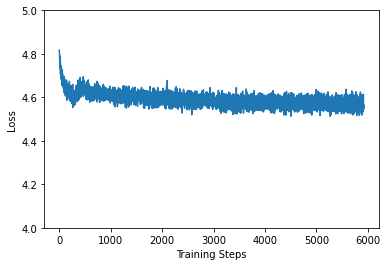

In [17]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([4,5])
plt.plot(batch_stats_callback.batch_losses)

In [18]:
test_dir = str(data_root) + "/val"

test_img_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
test_img_data = image_generator.flow_from_directory(str(test_dir), target_size=IMAGE_SHAPE)

Found 3925 images belonging to 10 classes.


In [19]:
test_img_data.samples/test_img_data.batch_size

122.65625

In [20]:
# test model accuracy
num_batches = int(np.ceil(test_img_data.samples/test_img_data.batch_size))
test_steps = 0
test_loss = 0
test_acc = 0
for test_img_batch, test_label_batch in test_img_data:
  test_steps += 1
  batch_loss, batch_acc = clean_model.train_on_batch(test_img_batch, test_label_batch)
  # ひとつだけ数が少ないバッチがあるので調整
  test_loss += batch_loss*len(test_img_batch)
  test_acc += batch_acc*len(test_img_batch)
  if(test_steps >= num_batches):
    break
test_loss /= test_img_data.samples
test_acc /= test_img_data.samples
print(test_loss, test_acc)

1.9813336851946108 0.92993630574767


In [21]:
only_clean_eff_model = effnet.EfficientNetB0(input_shape=(224,224,3))

#only_clean_eff_model.summary()
last_dense = layers.Dense(image_data.num_classes, activation='softmax')
only_clean_output = last_dense(only_clean_eff_model.output)
only_clean_model = tf.keras.Model(inputs=only_clean_eff_model.input, outputs=only_clean_output)

only_clean_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 112, 112, 32) 864         input_4[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 112, 112, 32) 128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 112, 112, 32) 0           stem_bn[0][0]                    
____________________________________________________________________________________________

In [22]:
only_clean_model.compile(
  optimizer=tf.keras.optimizers.RMSprop(decay=0.9, momentum=0.9),
  loss='categorical_crossentropy',
  metrics=['acc']
)

only_clean_history = only_clean_model.fit(
    image_data,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    callbacks=[batch_stats_callback],
)

Epoch 1/20
296/296 [==============================] - 154s 519ms/step - loss: 2.1426 - acc: 0.8125
Epoch 2/20
296/296 [==============================] - 154s 521ms/step - loss: 2.1281 - acc: 0.9062
Epoch 3/20
296/296 [==============================] - 157s 529ms/step - loss: 2.1361 - acc: 0.8750
Epoch 4/20
296/296 [==============================] - 156s 527ms/step - loss: 2.1309 - acc: 0.9062
Epoch 5/20
296/296 [==============================] - 157s 529ms/step - loss: 2.1164 - acc: 0.9375
Epoch 6/20
296/296 [==============================] - 152s 515ms/step - loss: 2.0960 - acc: 0.8750
Epoch 7/20
296/296 [==============================] - 155s 525ms/step - loss: 2.1087 - acc: 0.9375
Epoch 8/20
296/296 [==============================] - 154s 521ms/step - loss: 2.1004 - acc: 0.9375
Epoch 9/20
296/296 [==============================] - 153s 518ms/step - loss: 2.1002 - acc: 0.9688
Epoch 10/20
296/296 [==============================] - 152s 514ms/step - loss: 2.0908 - acc: 0.9062
Epoch 11/

In [23]:
# test on;y clean image model accuracy
num_batches = int(np.ceil(test_img_data.samples/test_img_data.batch_size))
test_steps = 0
test_loss = 0
test_acc = 0
for test_img_batch, test_label_batch in test_img_data:
  test_steps += 1
  batch_loss, batch_acc = only_clean_model.train_on_batch(test_img_batch, test_label_batch)
  # ひとつだけ数が少ないバッチがあるので調整
  test_loss += batch_loss*len(test_img_batch)
  test_acc += batch_acc*len(test_img_batch)
  if(test_steps >= num_batches):
    break
test_loss /= test_img_data.samples
test_acc /= test_img_data.samples
print(test_loss, test_acc)

2.0928357241563735 0.9215286624355681
